## Test the LBFGS algorithm on the FWI example with various values of $m$.

### This table summarizes the total numbers of functions, gradients, and backtracking steps evaluated with respect to different values of m:



| m |  1 | 3 |5|8|10|15|20|30|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| total func. evals | 22| 10 | 4| 4|2 |4 | 3| 4 |
| total grad. evals |69| 51 |47| 31|29 |30  |30 |38 |
| total backtracking steps | 22 |10 | 4| 4|2 |4 |3 | 4 |
| total run time (in sec) | 5456|4237 | 4148| 2811|2725 |3062 | 2844| 3562|

# a) $m = 3$

In [1]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 3
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 35.48607301712036 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(xn

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.001016305 dfp = -0.000192289
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.001016305    f(x)-f(xn)=0.00014881999999999992
||p||=2.054193272309108     ||df||=0.00011568102696639584    dfp=-0.000192289 
c*alpha*dfp=-1.92289e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000867485 ||df|| = 0.00017791767759275636
The total run time for this line search is: 35.263427734375 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 15 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.000867485 dfp = -0.000323539
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.000867485    f(x)-f(xn)=0.00023344999999999996
||p||=4.189212336466128     ||df||=0.00017791767759275636    dfp=-0.000323539 
c*alpha*dfp=-3.23539e-08
 
k = 15

 
i=0    alpha=1.0   f(x)=0.0001494795    f(x)-f(xn)=2.1001499999999992e-05
||p||=2.054195706353219     ||df||=6.782079327168033e-05    dfp=-3.31265e-05 
c*alpha*dfp=-3.3126500000000005e-09
 
k = 26 alpha = 1.0 f(xn) = 0.000128478 ||df|| = 6.633566160068053e-05
The total run time for this line search is: 35.78105282783508 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.000128478 dfp = -3.03321e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.000128478    f(x)-f(xn)=2.2822500000000014e-05
||p||=1.783423673724222     ||df||=6.633566160068053e-05    dfp=-3.03321e-05 
c*alpha*dfp=-3.03321e-09
 
k = 27 alpha = 1.0 f(xn) = 0.0001056555 ||df|| = 4.779215416781294e-05
The total run time for this line search is: 32.882065773010254 sec.
--------------------------

k = 38 alpha = 1.0 f(xn) = 4.904865e-05 ||df|| = 1.581676325927653e-05
The total run time for this line search is: 33.14681911468506 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 39 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 4.904865e-05 dfp = -4.27964e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=4.904865e-05    f(x)-f(xn)=3.203650000000001e-06
||p||=0.7123531427599656     ||df||=1.581676325927653e-05    dfp=-4.27964e-06 
c*alpha*dfp=-4.27964e-10
 
k = 39 alpha = 1.0 f(xn) = 4.5845e-05 ||df|| = 2.2597721124042574e-05
The total run time for this line search is: 33.25992774963379 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 40 of LBFGS:
i is the iteration counter for line 

||p||=1.0693268910861635     ||df||=1.8185791156834503e-05    dfp=-6.29837e-06 
c*alpha*dfp=-6.29837e-10
 
 
i=1    alpha=0.5   f(x)=2.302155e-05    f(x)-f(xn)=-4.2434999999999874e-07
||p||=1.0693268910861635     ||df||=1.8185791156834503e-05    dfp=-6.29837e-06 
c*alpha*dfp=-3.149185e-10
 
 
i=2    alpha=0.25   f(x)=2.302155e-05    f(x)-f(xn)=6.84950000000001e-07
||p||=1.0693268910861635     ||df||=1.8185791156834503e-05    dfp=-6.29837e-06 
c*alpha*dfp=-1.5745925e-10
 
k = 50 alpha = 0.25 f(xn) = 2.23366e-05 ||df|| = 1.8295901180319052e-05
The total run time for this line search is: 49.37294411659241 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 51 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 2.23366e-05 dfp = -1.58494e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=2.23366e-05    f(x)-f(xn)=9.52649

 
 The initial slowness:
 
colmax=4.5 colmin=2.5


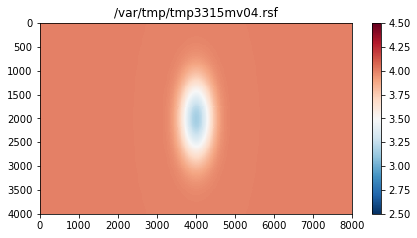

simplot: data min = 3.1607e+00, data max = 4.0000e+00


In [2]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


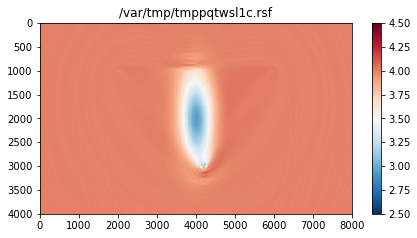

simplot: data min = 2.9514e+00, data max = 4.1110e+00


In [3]:
# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The target slowness:
 
colmax=4.5 colmin=2.5


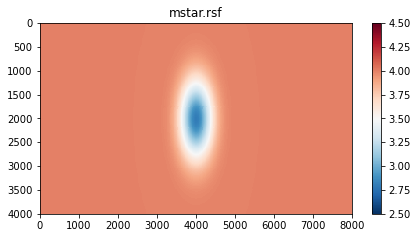

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [4]:
print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

 
 The initial data:
 
colmax=0.004 colmin=-0.004


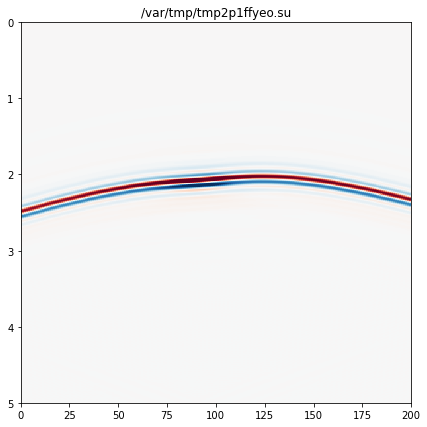

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


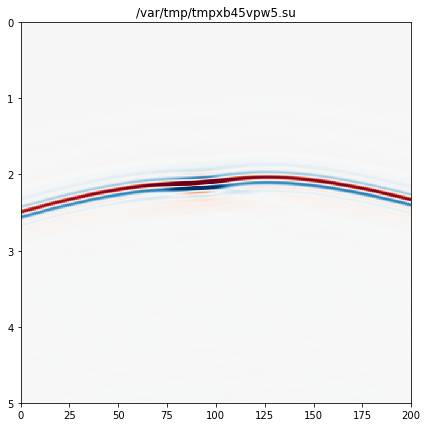

simplot: data min = -7.3681e-03, data max = 8.5892e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


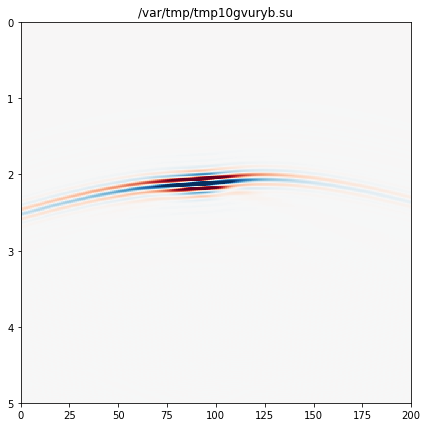

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


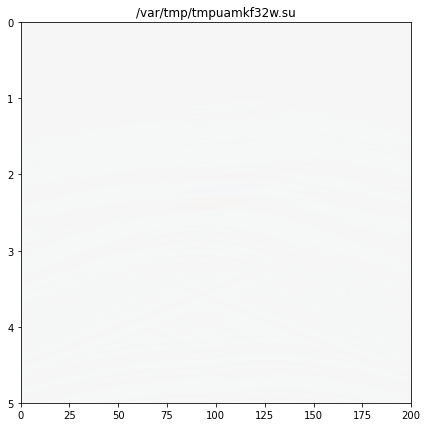

simplot: data min = -5.8861e-05, data max = 6.4272e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.9048e-07


In [5]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# b) $m = 5$

In [6]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 5
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 36.286303997039795 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(x

k = 13 alpha = 1.0 f(xn) = 0.001001795 ||df|| = 0.00013970576222905053
The total run time for this line search is: 34.06178116798401 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.001001795 dfp = -0.000144832
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.001001795    f(x)-f(xn)=0.00011576999999999996
||p||=1.1134989896717464     ||df||=0.00013970576222905053    dfp=-0.000144832 
c*alpha*dfp=-1.4483200000000002e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000886025 ||df|| = 0.00015700414007280188
The total run time for this line search is: 33.419682025909424 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 15 of LBFGS:
i is the iteration coun

 
Iteration 26 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0001577085 dfp = -2.02981e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0001577085    f(x)-f(xn)=1.4814000000000011e-05
||p||=1.402126955735464     ||df||=4.961511866356867e-05    dfp=-2.02981e-05 
c*alpha*dfp=-2.02981e-09
 
k = 26 alpha = 1.0 f(xn) = 0.0001428945 ||df|| = 7.672659252175872e-05
The total run time for this line search is: 35.287527084350586 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0001428945 dfp = -2.28552e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0001428945    f(x)-f(xn)=1.705350000000001e-05
||p||=1.56086194136445     ||df||=7.672659252175872e-05    dfp=-2.28552e-05 
c*alpha*dfp=-2.28552e-09
 
k =

k = 38 alpha = 0.5 f(xn) = 3.32913e-05 ||df|| = 2.7213967002258234e-05
The total run time for this line search is: 42.96796274185181 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 39 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 3.32913e-05 dfp = -1.54006e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=3.32913e-05    f(x)-f(xn)=1.0706499999999997e-06
||p||=0.19635223451746098     ||df||=2.7213967002258234e-05    dfp=-1.54006e-06 
c*alpha*dfp=-1.54006e-10
 
k = 39 alpha = 1.0 f(xn) = 3.222065e-05 ||df|| = 1.0620169490172932e-05
The total run time for this line search is: 35.13816022872925 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 40 of LBFGS:
i is the iteration counter for li

 
 The initial slowness:
 
colmax=4.5 colmin=2.5


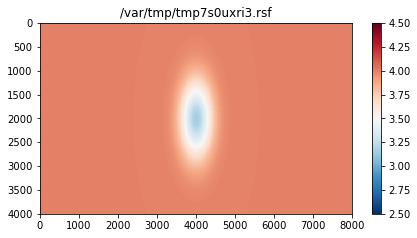

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


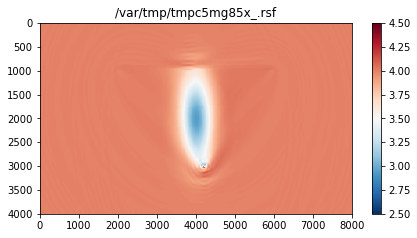

simplot: data min = 2.9443e+00, data max = 4.1254e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


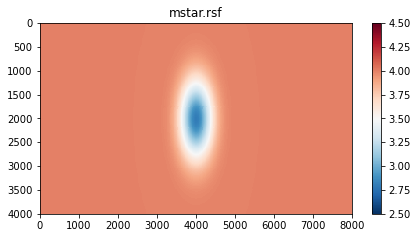

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


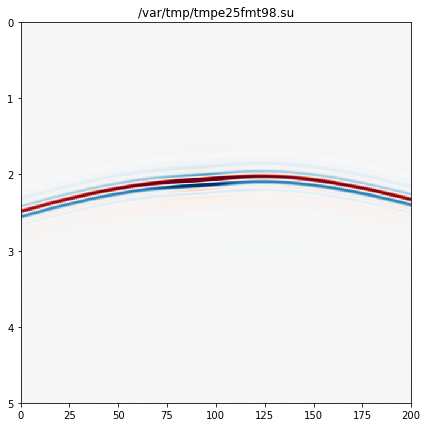

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


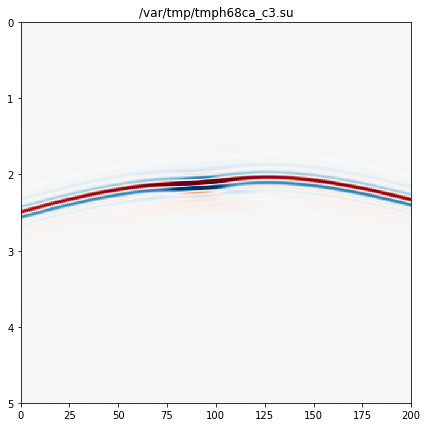

simplot: data min = -7.3614e-03, data max = 8.6195e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


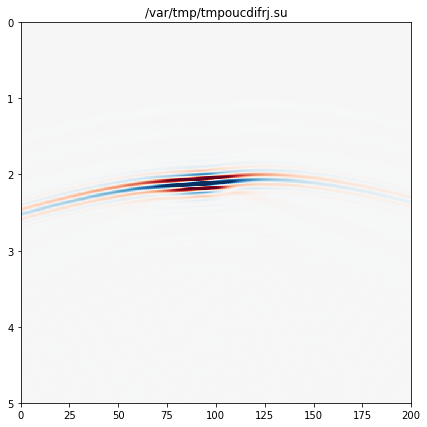

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


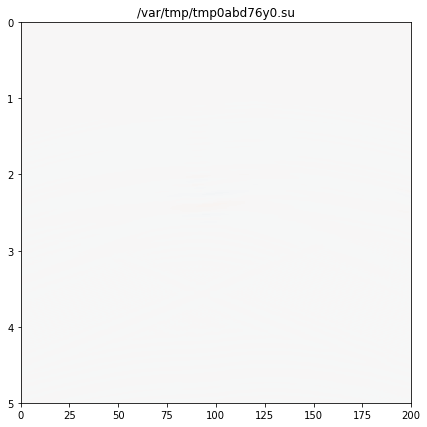

simplot: data min = -7.0132e-05, data max = 7.9463e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.7615e-07


In [7]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# c) $m = 8$

 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 33.758671045303345 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(x

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0003745115 dfp = -0.000316147
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0003745115    f(x)-f(xn)=0.00016367100000000003
||p||=6.020647805676727     ||df||=6.793408570077321e-05    dfp=-0.000316147 
c*alpha*dfp=-3.1614700000000006e-08
 
k = 14 alpha = 1.0 f(xn) = 0.0002108405 ||df|| = 7.903739621217288e-05
The total run time for this line search is: 31.670684099197388 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 15 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002108405 dfp = -7.17286e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002108405    f(x)-f(xn)=4.811899999999998e-05
||p||=2.0885114316182234     ||df||=7.903739621217288e-05    dfp=-7.17286e-05 
c*alpha*dfp=-7.17

||p||=0.3881455912412249     ||df||=1.8822885007352088e-05    dfp=-4.14222e-06 
c*alpha*dfp=-4.1422199999999996e-10
 
k = 26 alpha = 1.0 f(xn) = 3.485625e-05 ||df|| = 1.1045225212733328e-05
The total run time for this line search is: 30.782117128372192 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 3.485625e-05 dfp = -5.71628e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=3.485625e-05    f(x)-f(xn)=3.970549999999995e-06
||p||=0.6974460552616238     ||df||=1.1045225212733328e-05    dfp=-5.71628e-06 
c*alpha*dfp=-5.71628e-10
 
k = 27 alpha = 1.0 f(xn) = 3.08857e-05 ||df|| = 1.0860478810807559e-05
The total run time for this line search is: 30.183016777038574 sec.
-----------------------------------------------------------------------------
----------------

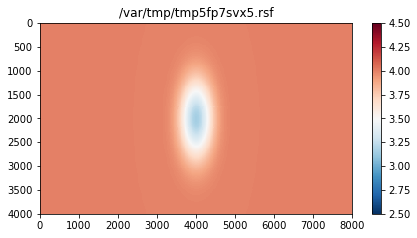

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


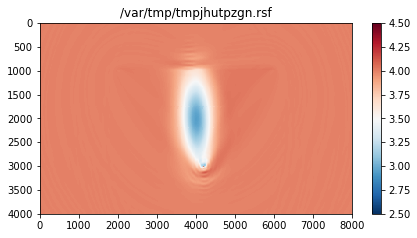

simplot: data min = 2.9510e+00, data max = 4.1118e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


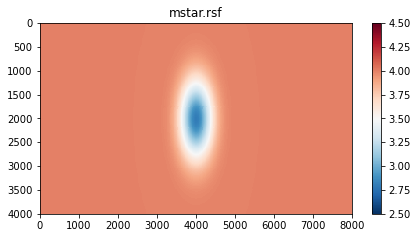

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


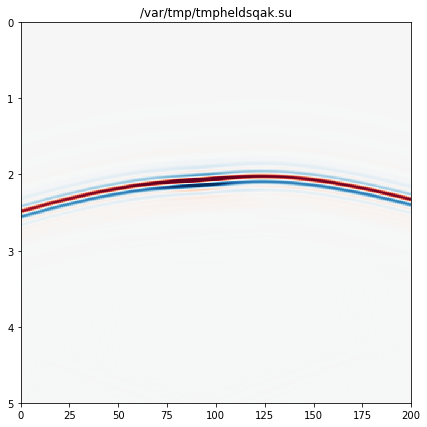

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


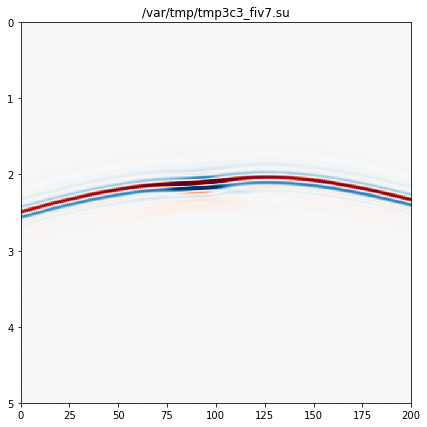

simplot: data min = -7.4003e-03, data max = 8.6092e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


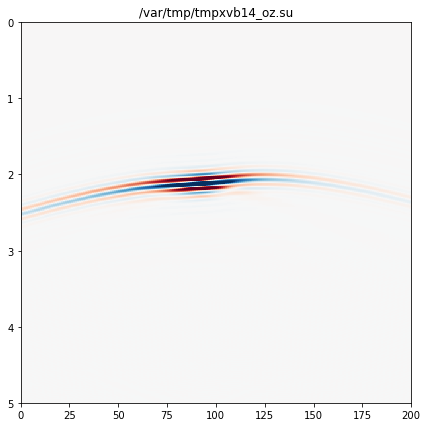

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


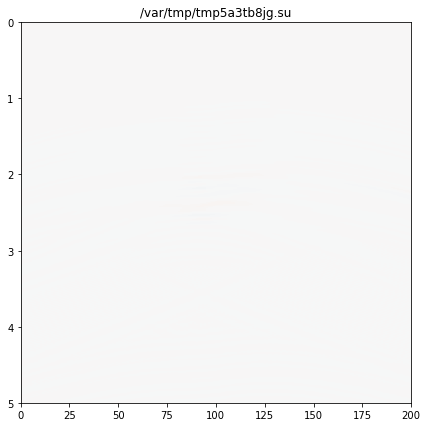

simplot: data min = -7.9137e-05, data max = 9.2556e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 3.0940e-07


In [8]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 8
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# d) $m = 10$

 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 36.721583127975464 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(x

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.00089909 dfp = -0.000226793
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.00089909    f(x)-f(xn)=0.00017961499999999994
||p||=2.8852348257984133     ||df||=0.00011189146526880412    dfp=-0.000226793 
c*alpha*dfp=-2.26793e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000719475 ||df|| = 0.00013618994089138888
The total run time for this line search is: 35.233842849731445 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 15 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.000719475 dfp = -0.000428065
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.000719475    f(x)-f(xn)=0.000294325
||p||=5.882686461133213     ||df||=0.00013618994089138888    dfp=-0.000428065 
c*alpha*dfp=-4.28065e-08
 
k = 15 alpha = 

||p||=1.0643025885527104     ||df||=1.1781128978158248e-05    dfp=-5.23567e-06 
c*alpha*dfp=-5.235670000000001e-10
 
k = 26 alpha = 1.0 f(xn) = 3.32726e-05 ||df|| = 1.4603732399629897e-05
The total run time for this line search is: 31.496788024902344 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 3.32726e-05 dfp = -7.92443e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=3.32726e-05    f(x)-f(xn)=5.142799999999998e-06
||p||=1.6644849053085462     ||df||=1.4603732399629897e-05    dfp=-7.92443e-06 
c*alpha*dfp=-7.92443e-10
 
k = 27 alpha = 1.0 f(xn) = 2.81298e-05 ||df|| = 1.695547109342586e-05
The total run time for this line search is: 30.56433892250061 sec.
-----------------------------------------------------------------------------
----------------------

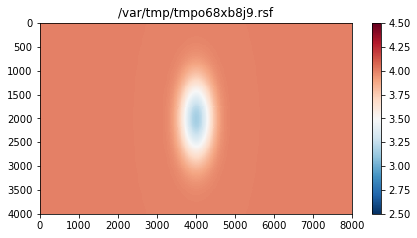

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


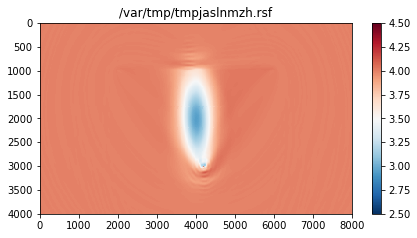

simplot: data min = 2.9489e+00, data max = 4.1098e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


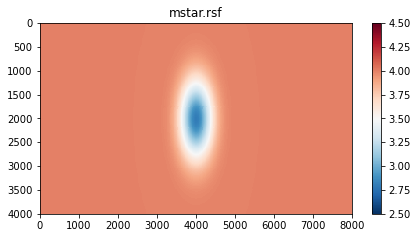

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


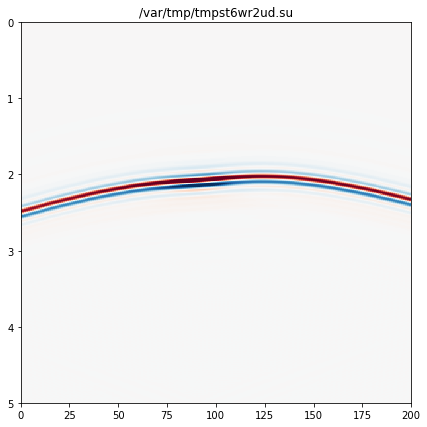

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


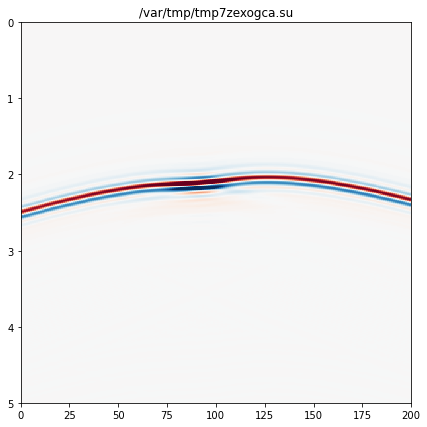

simplot: data min = -7.3641e-03, data max = 8.5918e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


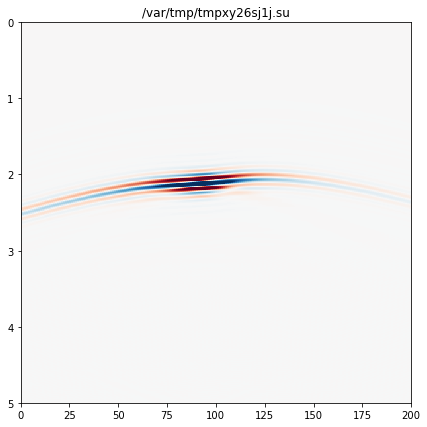

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


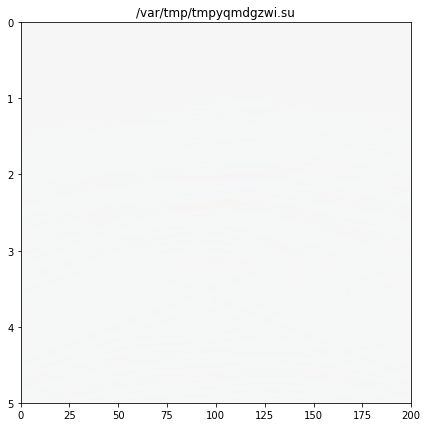

simplot: data min = -7.5162e-05, data max = 8.6762e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.9432e-07


In [9]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 10
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# e) $m = 15$

 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 34.39808487892151 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(xn

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.00126296 dfp = -0.000866991
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.00126296    f(x)-f(xn)=-0.00108684
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-8.66991e-08
 
 
i=1    alpha=0.5   f(x)=0.00126296    f(x)-f(xn)=-0.00010508499999999999
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-4.334955e-08
 
 
i=2    alpha=0.25   f(x)=0.00126296    f(x)-f(xn)=7.548500000000014e-05
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-2.1674775e-08
 
k = 14 alpha = 0.25 f(xn) = 0.001187475 ||df|| = 0.0001996724818296202
The total run time for this line search is: 47.7945032119751 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iterat

 
i=0    alpha=1.0   f(x)=3.75357e-05    f(x)-f(xn)=3.1186499999999977e-06
||p||=0.6184682691941439     ||df||=1.0297912409804231e-05    dfp=-4.28029e-06 
c*alpha*dfp=-4.2802899999999996e-10
 
k = 26 alpha = 1.0 f(xn) = 3.441705e-05 ||df|| = 1.0173544121887908e-05
The total run time for this line search is: 37.45728802680969 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 3.441705e-05 dfp = -5.64897e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=3.441705e-05    f(x)-f(xn)=4.373250000000004e-06
||p||=0.9964246082870495     ||df||=1.0173544121887908e-05    dfp=-5.64897e-06 
c*alpha*dfp=-5.648970000000001e-10
 
k = 27 alpha = 1.0 f(xn) = 3.00438e-05 ||df|| = 1.0290869739725598e-05
The total run time for this line search is: 36.54561686515808 sec.
-----------

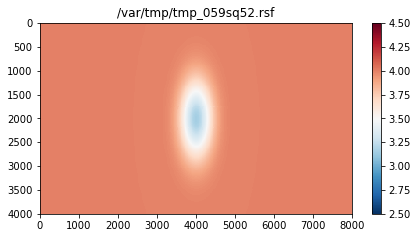

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


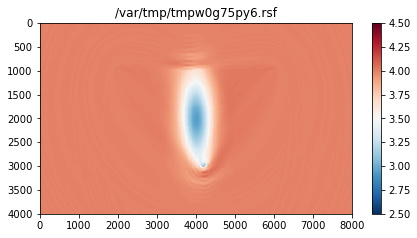

simplot: data min = 2.9476e+00, data max = 4.0785e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


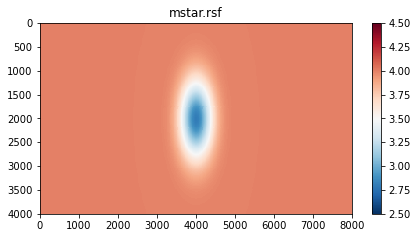

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


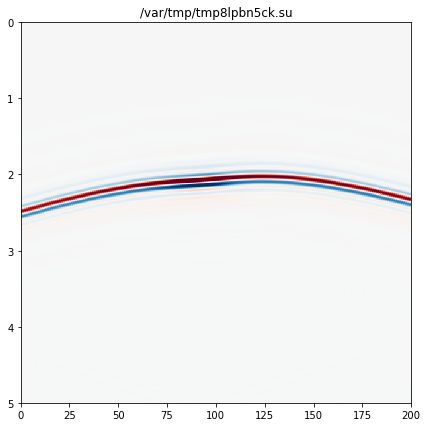

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


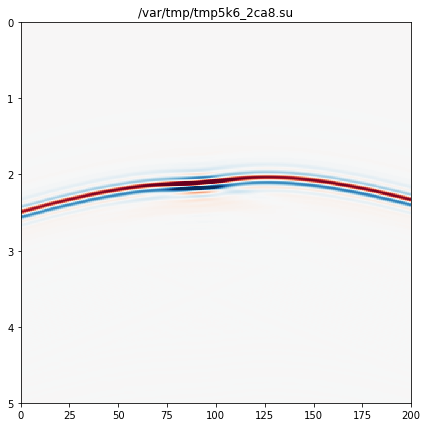

simplot: data min = -7.3662e-03, data max = 8.6016e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


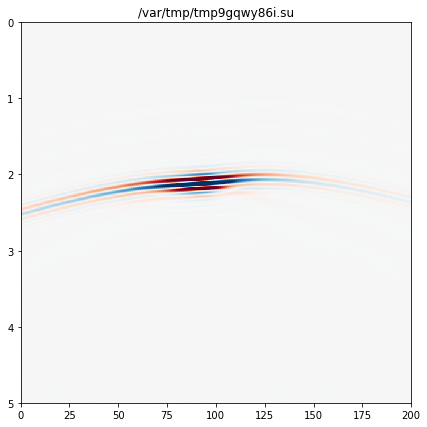

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


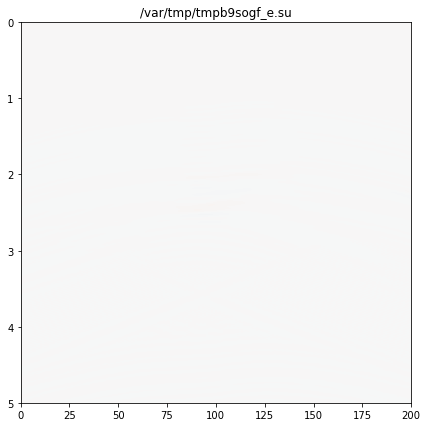

simplot: data min = -7.0713e-05, data max = 6.4518e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.6559e-07


In [10]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 15
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# f) $m = 20$

 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 35.73221397399902 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(xn

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.00126296 dfp = -0.000866991
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.00126296    f(x)-f(xn)=-0.00108684
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-8.66991e-08
 
 
i=1    alpha=0.5   f(x)=0.00126296    f(x)-f(xn)=-0.00010508499999999999
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-4.334955e-08
 
 
i=2    alpha=0.25   f(x)=0.00126296    f(x)-f(xn)=7.548500000000014e-05
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-2.1674775e-08
 
k = 14 alpha = 0.25 f(xn) = 0.001187475 ||df|| = 0.0001996724818296202
The total run time for this line search is: 48.172857999801636 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iter

 
i=0    alpha=1.0   f(x)=7.4761e-05    f(x)-f(xn)=1.6067499999999995e-05
||p||=1.0497190100212532     ||df||=3.0435160587714993e-05    dfp=-2.50606e-05 
c*alpha*dfp=-2.50606e-09
 
k = 26 alpha = 1.0 f(xn) = 5.86935e-05 ||df|| = 1.4648924875225485e-05
The total run time for this line search is: 35.20944786071777 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 5.86935e-05 dfp = -1.03126e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=5.86935e-05    f(x)-f(xn)=7.645000000000006e-06
||p||=0.9367774548952382     ||df||=1.4648924875225485e-05    dfp=-1.03126e-05 
c*alpha*dfp=-1.03126e-09
 
k = 27 alpha = 1.0 f(xn) = 5.10485e-05 ||df|| = 1.3370863846438643e-05
The total run time for this line search is: 35.26054096221924 sec.
------------------------------------

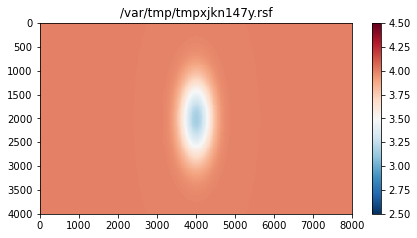

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


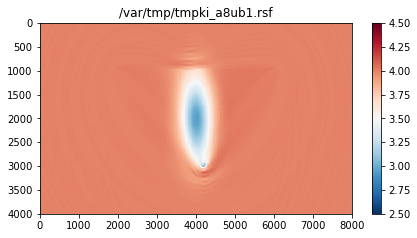

simplot: data min = 2.9530e+00, data max = 4.1131e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


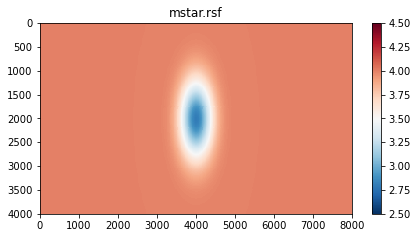

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


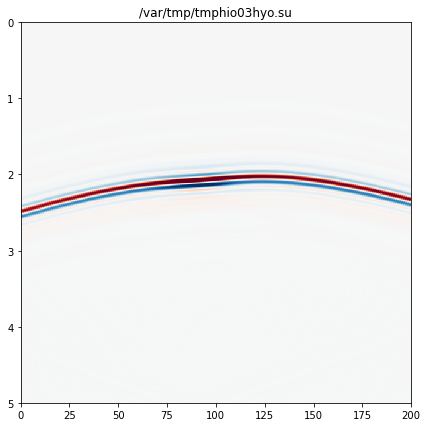

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


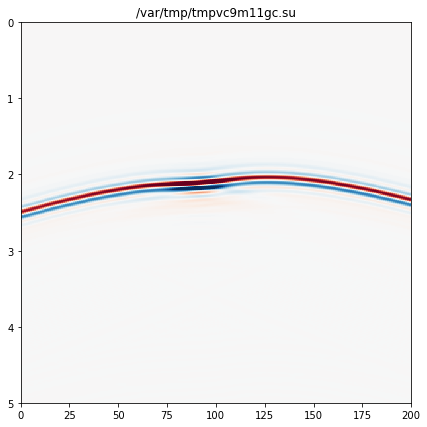

simplot: data min = -7.3894e-03, data max = 8.5916e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


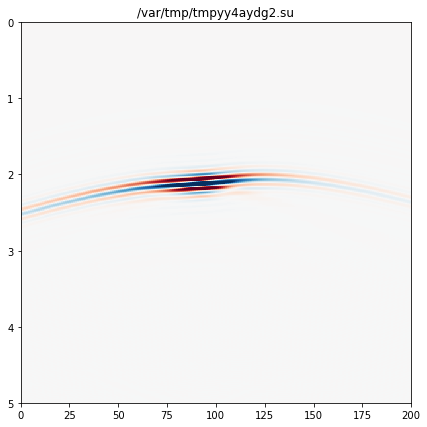

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


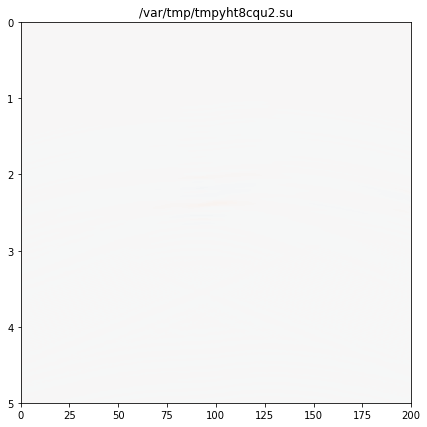

simplot: data min = -7.1073e-05, data max = 1.2378e-04
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 3.3339e-07


In [11]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 20
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

# g) $m = 30$

 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 36.555644273757935 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0264904
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.017721
||p||=5.028677758616076     ||df||=0.005267864842609385    dfp=-0.0264904 
c*alpha*dfp=-2.6490400000000002e-06
 
k = 2 alpha = 1.0 f(x

 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.00126296 dfp = -0.000866991
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.00126296    f(x)-f(xn)=-0.00108684
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-8.66991e-08
 
 
i=1    alpha=0.5   f(x)=0.00126296    f(x)-f(xn)=-0.00010508499999999999
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-4.334955e-08
 
 
i=2    alpha=0.25   f(x)=0.00126296    f(x)-f(xn)=7.548500000000014e-05
||p||=2.701049795912693     ||df||=0.0003209828655863113    dfp=-0.000866991 
c*alpha*dfp=-2.1674775e-08
 
k = 14 alpha = 0.25 f(xn) = 0.001187475 ||df|| = 0.0001996724818296202
The total run time for this line search is: 52.40448474884033 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Itera

 
i=0    alpha=1.0   f(x)=0.0003269595    f(x)-f(xn)=3.140199999999998e-05
||p||=0.9093805584022565     ||df||=4.924510127921355e-05    dfp=-4.47825e-05 
c*alpha*dfp=-4.47825e-09
 
k = 26 alpha = 1.0 f(xn) = 0.0002955575 ||df|| = 6.951510627194639e-05
The total run time for this line search is: 36.00114607810974 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 27 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002955575 dfp = -2.43499e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002955575    f(x)-f(xn)=-3.034000000000012e-06
||p||=0.3502827429377588     ||df||=6.951510627194639e-05    dfp=-2.43499e-05 
c*alpha*dfp=-2.43499e-09
 
 
i=1    alpha=0.5   f(x)=0.0002955575    f(x)-f(xn)=5.404999999999993e-06
||p||=0.3502827429377588     ||df||=6.951510627194639e-05    dfp=-2.43499e-05 
c*alpha*dfp=-1.217

total function evals = 4
total gradient evals = 38
total backtracking steps = 4
The total run time for program is 3562.3155550956726 sec.
 
 The initial slowness:
 
colmax=4.5 colmin=2.5


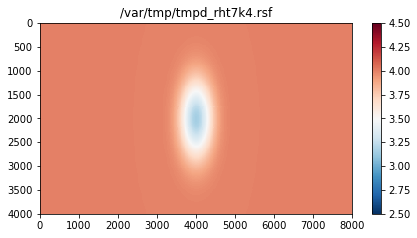

simplot: data min = 3.1607e+00, data max = 4.0000e+00
 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


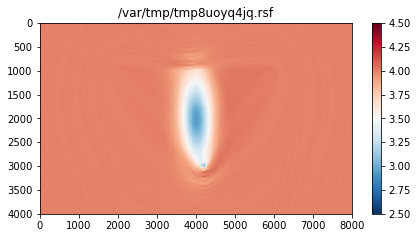

simplot: data min = 2.9491e+00, data max = 4.0818e+00
 
 The target slowness:
 
colmax=4.5 colmin=2.5


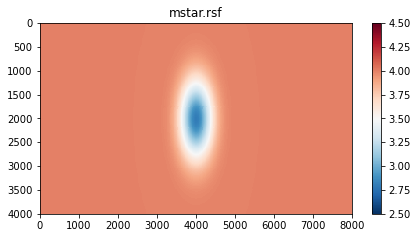

simplot: data min = 2.8009e+00, data max = 4.0000e+00
 
 The initial data:
 
colmax=0.004 colmin=-0.004


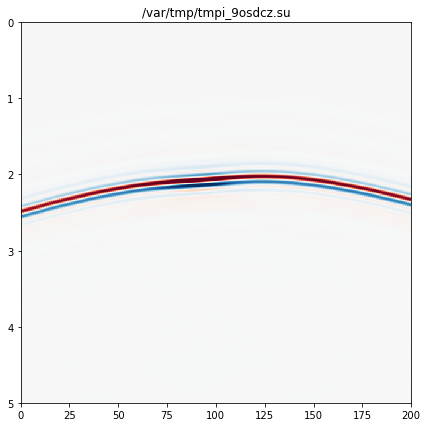

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


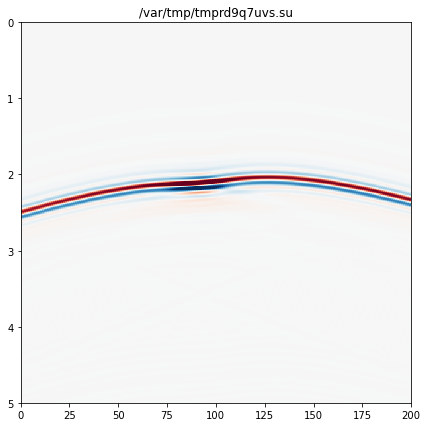

simplot: data min = -7.3661e-03, data max = 8.5952e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


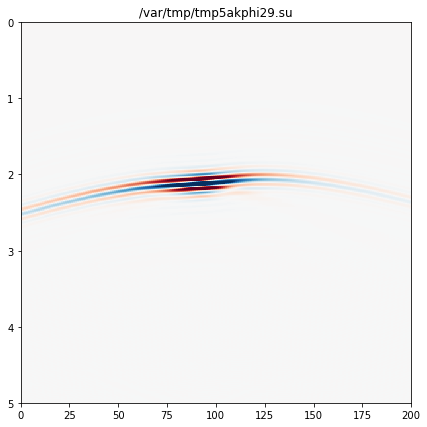

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


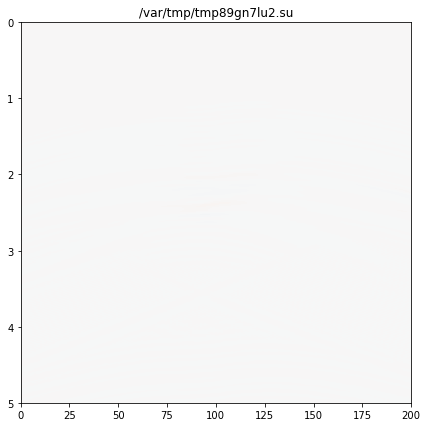

simplot: data min = -6.7022e-05, data max = 7.5274e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.7818e-07


In [12]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 30
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))